In [3]:
import pandas as pd
import numpy as np
import plotnine 
from plotnine import *
import os, sys, gc
from tqdm.notebook import tqdm

In [1]:
path = '../data/books/'

In [4]:
books = pd.read_csv(path + "books.csv")             # 책의 메타 정보
book_tags = pd.read_csv(path + "book_tags.csv")     # 책-태그의 매핑 정보
ratings = pd.read_csv(path + "ratings.csv")         # 사용자가 책에 대해 점수를 준 평점정보
tags = pd.read_csv(path + "tags.csv")               # 태그의 정보
to_read = pd.read_csv(path + "to_read.csv")         # 사용자가 읽으려고 기록해둔 책 (장바구니)

In [5]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [6]:
books.columns

Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')

In [7]:
books['small_image_url'].values[0]
# 책같은 경우에는 표지의 영향을 많이 받아서, 
# 표지에서 특징을 추출하고 CNN 모델로 유사한 책을 찾는 Contents Based Recommendation도 가능

'https://images.gr-assets.com/books/1447303603s/2767052.jpg'

In [8]:
# 필요한 변수들만 사용 
books = books[['book_id', 'authors', 'title', 'ratings_count', 'average_rating', 'language_code']].reset_index(drop=True)

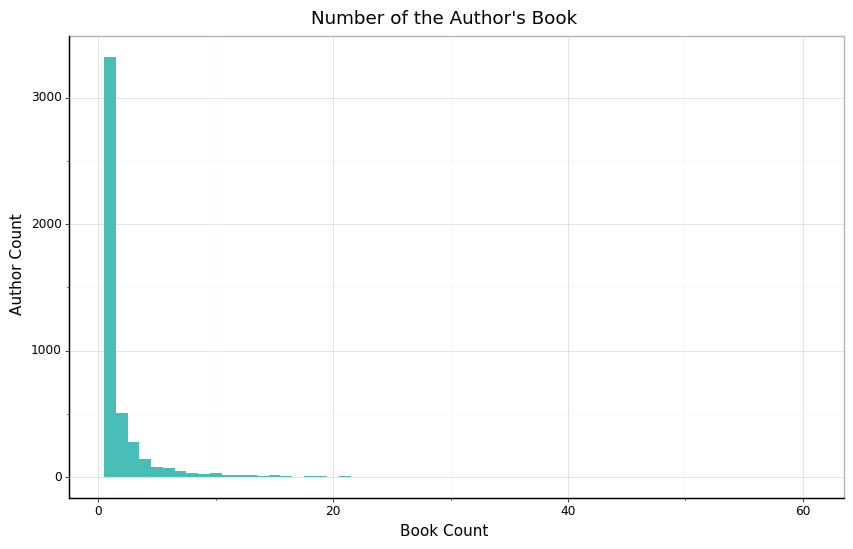

<ggplot: (159727178698)>

In [9]:
agg = books.groupby('authors')['authors'].agg({'count'})
(ggplot(data = agg)
  + geom_histogram(aes(x='count'), binwidth = 1, fill = '#49beb7')
  + labs(title = "Number of the Author's Book",
         x = 'Book Count',
         y = 'Author Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [10]:
print("책의 숫자:", books['book_id'].nunique())
print("저자의 숫자:", books['authors'].nunique(), "\n")
print(pd.DataFrame(agg['count'].describe()).T)

책의 숫자: 10000
저자의 숫자: 4664 

        count      mean       std  min  25%  50%  75%   max
count  4664.0  2.144082  3.414442  1.0  1.0  1.0  2.0  60.0


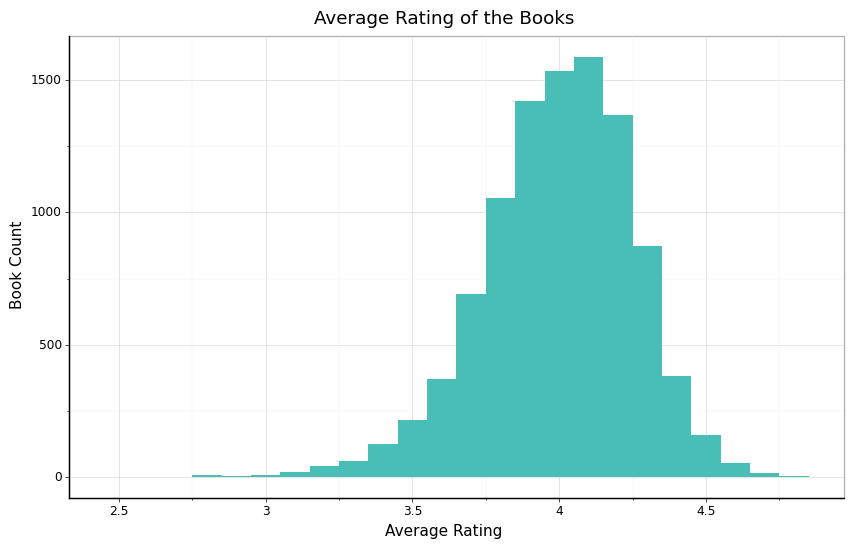

<ggplot: (159728104665)>

In [11]:
(ggplot(data = books)
  + geom_histogram(aes(x='average_rating'), binwidth = 0.1, fill = '#49beb7')
  + labs(title = "Average Rating of the Books",
         x = 'Average Rating',
         y = 'Book Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [12]:
books[books['average_rating'] <= 3].shape[0]

14

In [13]:
books.sort_values(by='average_rating', ascending=False).head()

,book_id,authors,title,ratings_count,average_rating,language_code
3627,24812,Bill Watterson,The Complete Calvin and Hobbes,28900,4.82,eng
3274,8,"J.K. Rowling, Mary GrandPré","Harry Potter Boxed Set, Books 1-5 (Harry Potte...",33220,4.77,eng
861,17332218,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)",73572,4.77,eng
8853,95602,Francine Rivers,Mark of the Lion Trilogy,9081,4.76,en-US
7946,5031805,"Anonymous, Lane T. Dennis, Wayne A. Grudem",ESV Study Bible,8953,4.76,eng
